[1] Downloading 7974.T from 2018-01-01 to 2022-12-31 ...
[2] Columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
[3] Calculating moving averages (MA20 / MA50 / MA200) ...
[4] Saving CSV to: nintendo_2018_2022.csv
[5] Saving to SQLite DB: nintendo.db (table: nintendo)
[5] Done. SQLite への保存完了。
[6] Plotting (optional) ...


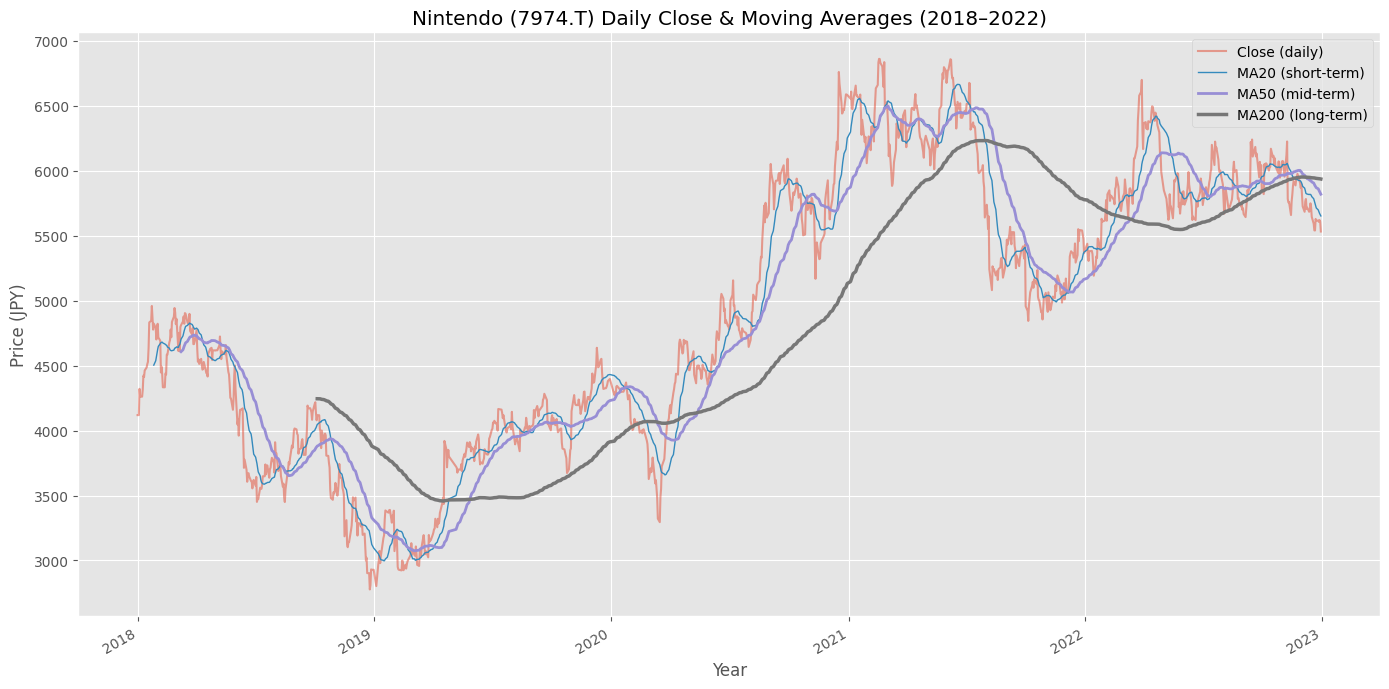

すべて完了です。nintendo.db を sqlite3 で開いて .schema nintendo を確認してみてください。


In [6]:
import yfinance as yf
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ============================================
# 1. 任天堂（7974.T）の株価データ取得
# ============================================
ticker = "7974.T"
start_date = "2018-01-01"
end_date   = "2022-12-31"

print(f"[1] Downloading {ticker} from {start_date} to {end_date} ...")

ntd = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=False
)

if ntd.empty:
    raise SystemExit("データが取得できませんでした。ティッカーや日付を確認してください。")

# 警告回避のため copy()
nt = ntd.copy()

# ============================================
# 2. yfinance の MultiIndex 列をフラット化
# ============================================
# 例: ('Close', '7974.T') → 'Close'
if isinstance(nt.columns, pd.MultiIndex):
    nt.columns = nt.columns.droplevel(1)

# 列名を確認したい場合（任意）
print("[2] Columns:", list(nt.columns))

# インデックスに名前を付ける（Date）
nt.index.name = "Date"

# ============================================
# 3. 移動平均の追加（短期・中期・長期）
# ============================================
print("[3] Calculating moving averages (MA20 / MA50 / MA200) ...")

nt["MA20"]  = nt["Close"].rolling(20).mean()
nt["MA50"]  = nt["Close"].rolling(50).mean()
nt["MA200"] = nt["Close"].rolling(200).mean()

# ============================================
# 4. CSV に保存（おまけ）
# ============================================
csv_path = "nintendo_2018_2022.csv"
print(f"[4] Saving CSV to: {csv_path}")

nt.to_csv(
    csv_path,
    encoding="utf-8-sig",  # Excel 用
    index=True             # 先頭列に Date を出力
)

# ============================================
# 5. SQLite に保存
# ============================================
db_path    = "nintendo.db"
table_name = "nintendo"

print(f"[5] Saving to SQLite DB: {db_path} (table: {table_name})")

# Date を列として持たせる
df_for_db = nt.reset_index()   # Date, Open, High, ...

conn = sqlite3.connect(db_path)

df_for_db.to_sql(
    table_name,
    conn,
    if_exists="replace",  # 既にあれば作り直し
    index=False
)

conn.close()
print("[5] Done. SQLite への保存完了。")

# ============================================
# 6. おまけ：グラフ表示（動作確認）
# ============================================
print("[6] Plotting (optional) ...")

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 7))

nt["Close"].plot(ax=ax, alpha=0.5, label="Close (daily)")
nt["MA20"].plot(ax=ax, linewidth=1, label="MA20 (short-term)")
nt["MA50"].plot(ax=ax, linewidth=2, label="MA50 (mid-term)")
nt["MA200"].plot(ax=ax, linewidth=2.5, label="MA200 (long-term)")

ax.set_title("Nintendo (7974.T) Daily Close & Moving Averages (2018–2022)")
ax.set_xlabel("Year")
ax.set_ylabel("Price (JPY)")
ax.legend()

plt.tight_layout()
plt.show()

print("すべて完了です。nintendo.db を sqlite3 で開いて .schema nintendo を確認してみてください。")
